# APLICACIONES EN CIENCIAS DE COMPUTACION

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)


## DESAFIO: Algoritmo Genetico para resolver el problema de las N-Reynas

Se ha implementado un algoritmo genético para resolver el problema de las n-reinas. La clase Individual_nqueens implementa la estructura de un individuo, la cual mantiene 2 variables: chromosome y fitness. **Cromosome es una lista**, donde el elemento **i** indica la posicion de la reina en la columna **i**. El fitness es el nro de pares de reinas que no se atacan y se puede obtener llamando a la funcion fitness_nqueens(). La clase individuo también tiene implementado los siguientes operadores: cruzamiento de un punto (crossover_onepoint), cruzamiento uniforme (crossover_uniform), operador de mutacion de una posicion (mutate_position) y operador de mutacion swap (mutate_swap). 

Este desafio consiste en implementar el operador de cruzamiento en orden para permutaciones (crossover_orderpermutation) visto en clase (diapositivas 15-18).

Al final del notebook puede encontrar las cuestiones que seran evaluadas

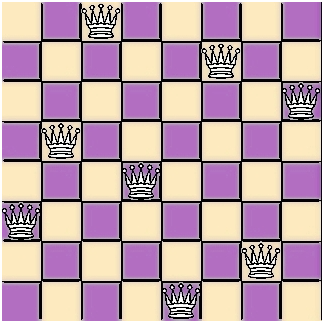

                                           [2    4    7    3     0    6    1     5] 


### Librerias a usar

In [1]:
import sys
import time
import random
import numpy as np
from copy import deepcopy
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math

 ### Estructura de individuo en el problema de las n-reinas 
Clase que implementa el individuo y sus operadores. El cromosoma de un individuo es una lista de numeros. El elemento i de esta lista (gen i) indica la fila en que se encuentra la reyna de la columna i. 

    Por ejemlo, el tablero de la figura se representa con el cromosoma:    [2,4,7,3,0,6,1,5]
 

In [2]:
class Individual(object):   
   
    def __init__(self, chromosome):
            self.chromosome = chromosome[:]
            self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
     
    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other"
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2]     
    
    def crossover_orderpermutation(self, other):
        "Uniform order-based crossover. Genera 2 cromosomas hijos  que tambien deben ser permutaciones" 
        "Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other" 
        "Escoge aleatoriamente la mitad de posiciones del cromosoma self y lo copia a un hijo ind1 en las mismas posiciones" 
        "Los numeros faltantes los copia de other en el mismo orden en que aparecen en other "
        "El hijo ind2 se crea de la misma forma intercambiando self por other"
        
        
        pos_constantes = []
        pos_constantes = random.sample(range(len(self.chromosome)),len(self.chromosome)//2)
        cromosomo1 = [-1]*len(self.chromosome) 
        cromosomo2 = [-1]*len(self.chromosome) 
        
        for index in pos_constantes:
            cromosomo1[index]= self.chromosome[index]
            cromosomo2[index] = other.chromosome[index]
            
        
        for i in range(len(self.chromosome)):
            if(cromosomo1[i] == -1):
                for j in range(len(other.chromosome)):
                    if other.chromosome[j] not in cromosomo1:
                        cromosomo1[i] = other.chromosome[j]
                        break
                        
                for j in range(len(self.chromosome)):
                    if self.chromosome[j] not in cromosomo2:
                        cromosomo2[i] = self.chromosome[j]
                        break          
        
        ind1 = Individual(cromosomo1)
        ind2 = Individual(cromosomo2)
        return [ind1, ind2]          
    
    
    def mutate_position(self): 
        """       mutate_position
        Cambia aleatoriamente un alelo de un gen."""
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(1,len(mutated_chromosome)) 
        newAllele = random.randrange(1,len(mutated_chromosome))
        mutated_chromosome[mutGene] = newAllele
        return Individual(mutated_chromosome)    
        
    def mutate_swap(self):
        "Escoge dos genes e intercambia sus alelos"
        mutated_chromosome = deepcopy(self.chromosome[:])
        mutGen1 = random.randrange(1,len(mutated_chromosome))
        mutGen2 = random.randrange(1,len(mutated_chromosome))
        temp = mutated_chromosome[mutGen1]
        mutated_chromosome[mutGen1] = mutated_chromosome[mutGen2]
        mutated_chromosome[mutGen2] = temp
        return Individual(mutated_chromosome)    

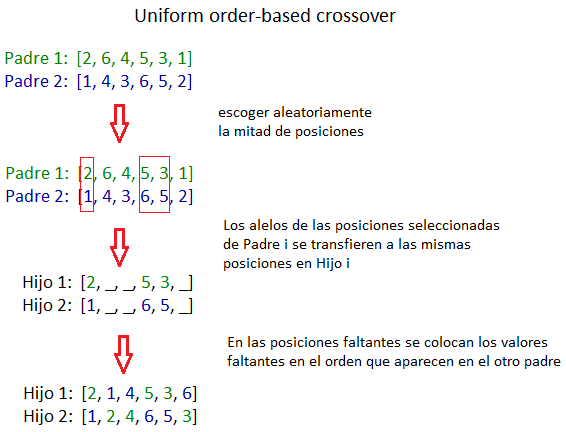

### Funciones para inicializar y visualizar Poblaciones

In [3]:
def init_population(pop_number, size_chromosoma):
    population = []
    state_length=2
    ## Crea la poblacion inicial con cromosomas aleatorios (permutaciones)
    for i in range(pop_number):
        new_chromosome = [j for j in range(1,size_chromosoma+1)]
        random.shuffle(new_chromosome)
        population.append(Individual(new_chromosome))
    return population

Clase para displayar un tablero

In [4]:
class Board:
    def __init__(self, genes, size):
        board = [['.'] * size for _ in range(size)]
        for index in range(0, len(genes), 1):
            row = index
            column = genes[index ]
            board[column-1][row] = 'Q'
        self._board = board

    def get(self, row, column):
        return self._board[column][row]

    def print(self):
        # 0,0 imprime desde abajo comenzando en el extremo izquierdo
        for i in reversed(range(len(self._board))):
            print(' '.join(self._board[i]))

Funcion para mostrar una población y su fitnes 

In [5]:
def display_population(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness']
    return data

### Funcion de Fitness

Funcion para evaluar el fitness de un Cromosoma (tablero de n-reinas):  nro de pares de reinas no atacadas (maximo valor = n*(n-1)/2) 

In [6]:
def fitness_nqueens(chromosome):
    """Retorna el fitness de un cromosoma en el problema de las n-reinas (nro de pares de reinas no atacadas) """
    n = len(chromosome)  # nro de reinas
    fitness = 0
    for i in range(n-1):
        for j in range(i+1, n):
            # si el par de reinas i, j  no estan en la misma fila o diagonales => par no atacado
            if chromosome[j] not in [chromosome[i], chromosome[i] - (j-i),  chromosome[i] + (j-i)]:
                fitness = fitness + 1
    return fitness

Funcion para evaluar toda una población de individuos con la funcion de fitnes especificada

In [7]:
def evaluate_population(population, fitness_fn):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    for i in range(len(population)):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome)
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [8]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [9]:
def select_parents_torneo(population,size_torneo):
    
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

## Seleccion de sobrevivientes por Ranking

#### Seleccion de sobrevivientes por ranking

In [10]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

## Algoritmo Genetico
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen), metodoSeleccion (ruleta/torneo), tournament_size, taza de mutación (pmut), operador de cruzamiento (crossover) y operador de mutacion (mutation)

In [11]:
def genetic_algorithm(poblacion_inicial, fitness_fn, ngen=100, pmut=0.1, tournament_size=3,
                      crossover="onepoint", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico para el problema de la mochila
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial
    
    popsize = len(population)
    
    # Evalua la poblacion inicial
    evaluate_population(population, fitness_fn)  
    
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion
        
        ## Selecciona las parejas de padres (mating pool) para cruzamiento 
        mating_pool = []
        if selection_parents_method=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        elif selection_parents_method=="tournament" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,tournament_size))
        else:
            raise NotImplementedError
                
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":# cruzamiento 1 punto
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) 
            elif crossover == "uniform":# cruzamiento uniforme
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) 
            elif crossover == "orderpermutation":# cruzamiento uniforme
                offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) ) 
            else:
                raise NotImplementedError                
           
        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "position":
                    offspring_population[i] = offspring_population[i].mutate_position()   # mutacion de una posicion
                elif mutation == "swap":
                    offspring_population[i] = offspring_population[i].mutate_swap()      # mutacion swap
                else:
                    raise NotImplementedError
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn)  
        
        ## Selecciona popsize individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError        
  
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        print("generacion {}, best_fitness = {},best_cromosoma = {}".format(g, population[ibest[0]].fitness,population[ibest[0]].chromosome))
    
    return population[ibest[0]], bestfitness  

## Probando el Algoritmo genetico

In [12]:
## Crea la poblacion inicial con cromosomas aleatorios
size_chromosoma = 10      
num_individuals = 8

# Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial = init_population(num_individuals, size_chromosoma)

In [13]:
# n*(n-1)/2  Maximo valor del fitness  
print(int(size_chromosoma*(size_chromosoma-1)/2))

45


Llama al algoritmo genetico para encontrar una solucion al problema de las n reinas

Poblacion inicial, best_fitness = 42
generacion 0, best_fitness = 42,best_cromosoma = [5, 9, 2, 1, 10, 7, 3, 8, 6, 4]
generacion 1, best_fitness = 42,best_cromosoma = [5, 9, 2, 1, 10, 7, 3, 8, 6, 4]
generacion 2, best_fitness = 42,best_cromosoma = [5, 9, 2, 1, 10, 7, 3, 8, 6, 4]
generacion 3, best_fitness = 42,best_cromosoma = [5, 9, 2, 1, 10, 7, 3, 8, 6, 4]
generacion 4, best_fitness = 42,best_cromosoma = [5, 9, 2, 1, 10, 7, 3, 8, 6, 4]
generacion 5, best_fitness = 43,best_cromosoma = [2, 8, 5, 3, 7, 9, 4, 6, 1, 10]
generacion 6, best_fitness = 43,best_cromosoma = [2, 8, 5, 3, 7, 9, 4, 6, 1, 10]
generacion 7, best_fitness = 43,best_cromosoma = [2, 8, 5, 3, 7, 9, 4, 6, 1, 10]
generacion 8, best_fitness = 43,best_cromosoma = [2, 8, 5, 3, 7, 9, 4, 6, 1, 10]
generacion 9, best_fitness = 43,best_cromosoma = [2, 8, 5, 3, 7, 9, 4, 6, 1, 10]
generacion 10, best_fitness = 43,best_cromosoma = [2, 8, 5, 3, 7, 9, 4, 6, 1, 10]
generacion 11, best_fitness = 43,best_cromosoma = [2, 8, 5, 3, 7, 9, 4,

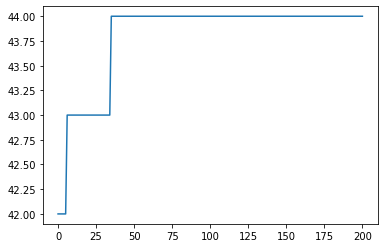

In [14]:
import matplotlib.pyplot as plt
ngen = 200 # Nro de generaciones
pmut = 0.1 # taza de mutación
fitness_fn=fitness_nqueens

metodoSeleccion=['roulette','tournament']
tournament_size = 3 #tamaño del torneo = 3

crossover=['onepoint','uniform', 'orderpermutation']
mutation=['position','swap']

lst_bestcrom=[]
best_ind, bestfitness = genetic_algorithm(poblacion_inicial, fitness_fn, ngen, pmut, tournament_size, 
                                          crossover[2], mutation[1], metodoSeleccion[0])
lst_bestcrom.append(best_ind)
plt.plot(bestfitness)
plt.show()

In [15]:
num_queens=size_chromosoma
candidato=lst_bestcrom[0].chromosome
board = Board(candidato,num_queens )
board.print()
print(candidato)

. . . . . . . . . Q
. . . . . Q . . . .
. Q . . . . . . . .
. . . . . . . . Q .
. . . . . . . Q . .
. . Q . . . . . . .
. . . . . . Q . . .
. . . Q . . . . . .
Q . . . . . . . . .
. . . . Q . . . . .
[2, 8, 5, 3, 1, 9, 4, 6, 7, 10]


## Tareas y cuestiones:

<b>1) Comparar el desempeño de los operadores de cruzamiento </b> 

En esta sección vamos a comparar el desempeño del operador de cruzamiento <b>crossover_uniform</b> versus <b>crossover_orderpermutation</b>. Para ello experimentaremos en el problema de 10 reinas, taza de mutación = 0 (a fin de centrarnos solo en el efecto de cruzamiento). Realize 10 corridas con lo siguiente

    - Generar una poblacion inicial P de 8 individuos 
    - Ejecutar el AG con poblacion inicial P y metodo de cruzamiento uniform
    - Ejecutar el AG con poblacion inicial P y metodo de cruzamiento orderpermutation
    - En ambas ejecuciones registre el fitness máximo obtenido y la primera generacion donde se obtiene dicho fitness

Los parametros del AG para cada corrida son 8 individuos, 200 generaciones, seleccion de padres = 'roulette'

Comparar los promedios de fitness máximos y generaciones de convergencia. Cuál operador tiende a encontrar mejores soluciones y Cuál tiende a convergir mas rapido?. Explique por qué


<b>2) Determinar la influencia de la mutacion </b> 

Realize 10 corridas de lo siguiente:

    - Generar una poblacion inicial P de 8 individuos
    - Ejecutar el AG con poblacion inicial P, cruzamiento uniform y mutacion mutate_position (pmut=0.20)
    - Ejecutar el AG con poblacion inicial P, cruzamiento uniform y mutacion mutate_position (pmut=0.80)
    - Ejecutar el AG con poblacion inicial P, cruzamiento orderpermutation y mutate_swap (pmut=0.20)
    - Ejecutar el AG con poblacion inicial P, cruzamiento orderpermutation y mutate_swap (pmut=0.80)
    - En todas las ejecuciones registre el fitness máximo obtenido y la primera generacion donde se obtiene dicho fitness
 
Los parametros del AG para cada corrida son 8 individuos, 200 generaciones, seleccion de padres = 'roulette'

En base a las medias del fitness máximo y generacion de convergencia indique como influye el operador de mutación y la tasa de mutación en los resultados e intente dar una explicación de los resultados